## Example with trained network

In [1]:
from model import heat_mortality_model
from model import config
import yaml
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from util import *

set parameters for the network

In [2]:
yaml_path = './state_dict/weekday_corr/hparams.yaml'
params_model = yaml.safe_load(Path(yaml_path).read_text())
params_model['population_dir'] = config.POPULATION_DIR
params_model['weather_dir'] = config.WEATHER_DIR
params_model['t_type'] = 'eval'     # eval mode prevent the model from loading temperature

load state dict for the network

In [3]:
model = heat_mortality_model.HeatMortality_EXP(**params_model)
state_file = './state_dict/weekday_corr/trained_state.ckpt'
state = torch.load(state_file, map_location=torch.device('cpu'))
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

load the district level temperature (estimation with neural network based on DWD station data) \
The capped temperature is used to estimate heat-related mortality \
The day of the week of the starting date is adjusted to Saturday to cope with the trainging data. \
The dimensions of the temperature tensor is characterized by [districts, time]

In [4]:
temp_pred_recent = torch.load('./data/district_T/interpolated_DWD/t_pred_recent.pt')[:, 1:]
capped_t = temp_pred_recent.clip(-100, 20)
temp_pred_recent.shape

torch.Size([400, 996])

The calculated factor are the effect of temperature on the mortality rate and cases. \
The dimensions of the factor tensor is characterized by [time, districts, age group, gender]. \
The predictors factors is shortened by 5 days because of the size of the convoluational kernel.

In [5]:
model.eval()
factor = model((temp_pred_recent / 15).float()).detach()
factor_capped = model((capped_t / 15).float()).detach()
factor.shape

torch.Size([991, 400, 15, 2])

Function to calculate estimated mortality based on the predicted factors. \
The function was selected to prevent negetive death rate. \
In this example, the base death case (rate) is selected to be the same as the end of 2020 (because of COVID)

In [6]:
pred_fn = lambda res: (0.99 + res.clip(-0.99) + 0.01 * (res.clip(max=-0.99) + 0.99).exp()) * model.basic_death_case[-1]

Then we get the estimation for district level daily mortality. \
The dimensions of the mortality tensor is characterized by [time, districts, age group, gender]

In [7]:
death_pred = pred_fn(factor)
death_capped_t = pred_fn(factor_capped)
death_pred.shape

torch.Size([991, 400, 15, 2])

We can plot the daily heat-related death by calculating the differences between real temperature and capped temperature. \
The negetive daily heat-related death is the result of short-term harvesting effect.

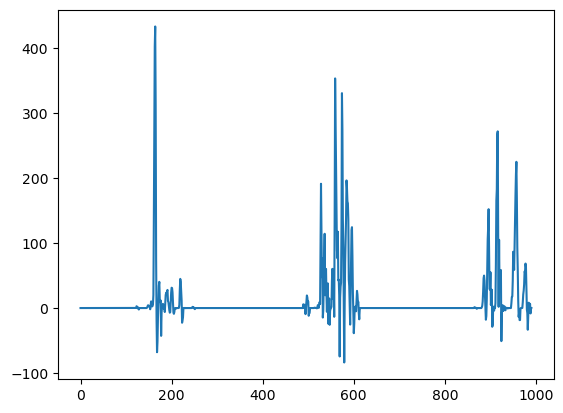

In [8]:
excess_death = death_pred - death_capped_t
plt.plot(excess_death.sum([1,2,3]))

We can use the data to plot the estimated yearly heat-related mortality. \
The map differs from the results in the paper becasue we use an ensemble of 20 objects.

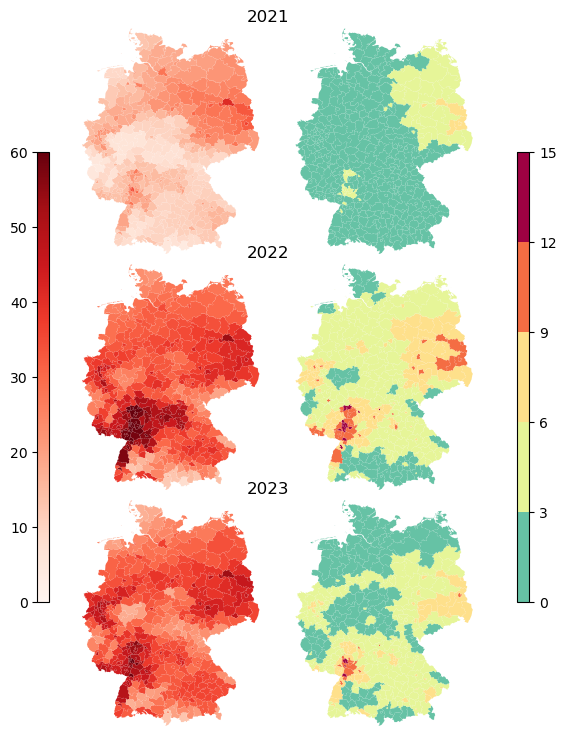

In [9]:
import matplotlib as mpl
import matplotlib.lines as lines
import numpy as np

cmap = mpl.colors.ListedColormap(['#66c2a5','#e6f598','#fee08b','#f46d43','#9e0142'])
cmap_blue = mpl.colors.ListedColormap(list(reversed(['#005eb8','#587bc7','#869ad5','#b0bbe3','#d8dcf1'])))
cmap_red = mpl.colors.ListedColormap(list(reversed(['#c10170','#d2528b','#e180a7','#eeabc3','#f8d5e1'])))
cmap_yellow = mpl.colors.ListedColormap(list(reversed(['#636b05','#83873e','#a3a36c','#c2c19b','#e0e0cc'])))

gdf = get_gdf()

day_counts = [0]
for i in range(2021, 2024):
    day_counts.append(day_counts[-1] + 365 + (i % 4 == 0))

t = temp_pred_recent[:, 5:] 

fig, ax = plt.subplots(3, 2, figsize=(6, 9))
cbar_ax1 = fig.add_axes([0.1, 0.25, 0.02, 0.5])
cbar_ax2 = fig.add_axes([0.9, 0.25, 0.02, 0.5])

pop = model.population[-1].sum([1,2])

for i in range(3):
    t_year = (t[:, day_counts[i]+150:day_counts[i]+270] > 20).sum(1)
    

    gdf['days'] = t_year

    im1 = gdf.plot(ax=ax[i][0], column='days', cmap='Reds', legend=True, markersize=1, aspect=1.5, vmin=0, vmax=60,
                   cax=cbar_ax1, legend_kwds={"orientation" : "vertical"})
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    ax[i][0].axis('off')

    ax[i][0].set_title(f'{2021 + i}', x=1, y=0.95)
    death = excess_death.sum([2,3])[day_counts[i]+150:day_counts[i]+270].sum(0) / pop * 100000
    gdf['death'] = death 

    im2 = gdf.plot(ax=ax[i][1], column='death', cmap=cmap, legend=True, markersize=1, aspect=1.5, vmin=0, vmax=15,
                   cax=cbar_ax2, legend_kwds={"orientation" : "vertical", 'ticks': np.arange(0,16,3)})
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    ax[i][1].axis('off')

cbar_ax1.yaxis.set_ticks_position('left')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=-0.2,
                    hspace=-0.05)